In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro_glm
import numpyro_glm.metric.models as glm_metric
import numpyro_glm.metric.plots as plots
import pandas as pd
from scipy.stats import norm, t

# Chapter 16: Metric-Predicted Variable on One or Two Groups

## Estimating Mean and Standard Deviation of a Normal distribution

### Metric Model

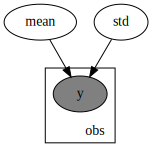

In [3]:
numpyro.render_model(
    glm_metric.one_group,
    model_args=(jnp.ones(5), ),
    render_params=True)

### Synthesis data

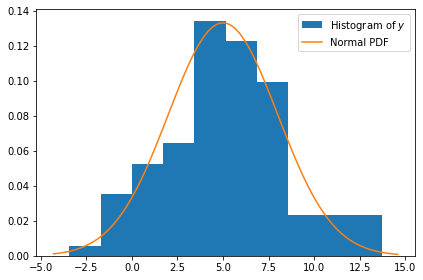

In [4]:
MEAN = 5
STD = 3
N = 100

y = np.random.normal(MEAN, STD, N)

# Plot the histogram and true PDF of normal distribution.
fig, ax = plt.subplots()
ax.hist(y, density=True, label='Histogram of $y$')
xmin, xmax = ax.get_xlim()
p = np.linspace(xmin, xmax, 1000)
ax.plot(p, norm.pdf(p, loc=MEAN, scale=STD), label='Normal PDF')
ax.legend()
fig.tight_layout()

Now, we'll try to apply the metric model on that data to see
if it can recover the parameter.

In [5]:
mcmc_key = random.PRNGKey(0)
kernel = NUTS(glm_metric.one_group)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, jnp.array(y))
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mean      5.22      0.35      5.24      4.63      5.76    388.86      1.00
       std      3.42      0.25      3.40      3.03      3.82    505.28      1.00

Number of divergences: 0


Plot diagnostics plot to see if the MCMC chains are well-behaved.

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

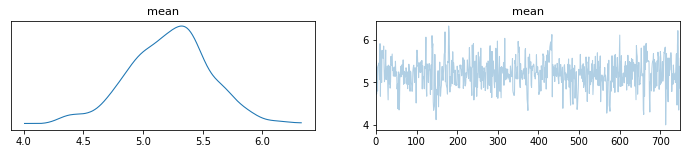

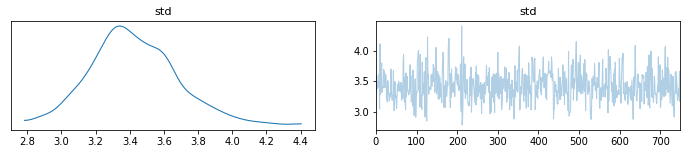

In [6]:
numpyro_glm.plot_diagnostic(mcmc, ['mean', 'std'])

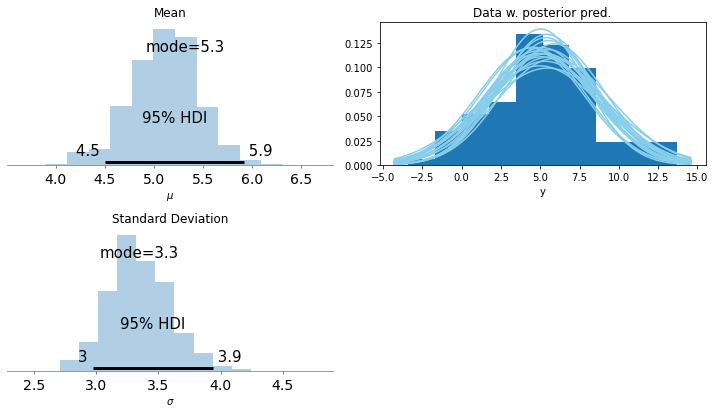

In [7]:
fig = plots.plot_st(mcmc, y)

### Smart Group IQ

In [8]:
iq_data = pd.read_csv('datasets/TwoGroupIQ.csv')
iq_data['Group'] = iq_data['Group'].astype('category')
smart_group_data = iq_data[iq_data.Group == 'Smart Drug']
smart_group_data.describe()

,Score
count,63.000000
mean,107.841270
std,25.445201
min,50.000000
25%,96.000000
50%,107.000000
75%,119.000000
max,208.000000


Then, we will apply the one group model to the data
and plot the results.

In [9]:
mcmc_key = random.PRNGKey(0)
kernel = NUTS(glm_metric.one_group)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, jnp.array(smart_group_data.Score.values))
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mean    107.84      3.29    107.93    102.89    113.40    459.59      1.00
       std     26.03      2.35     25.83     22.28     29.97    360.22      1.01

Number of divergences: 0


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

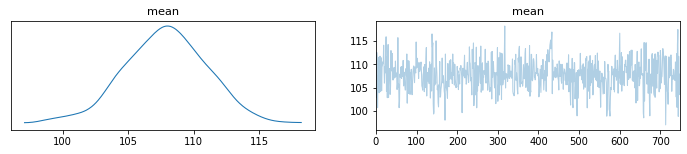

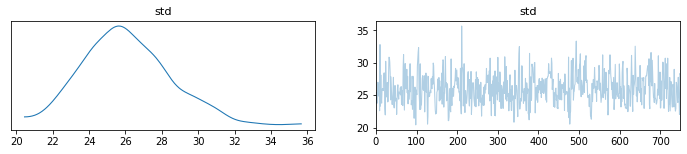

In [10]:
numpyro_glm.plot_diagnostic(mcmc, ['mean', 'std'])

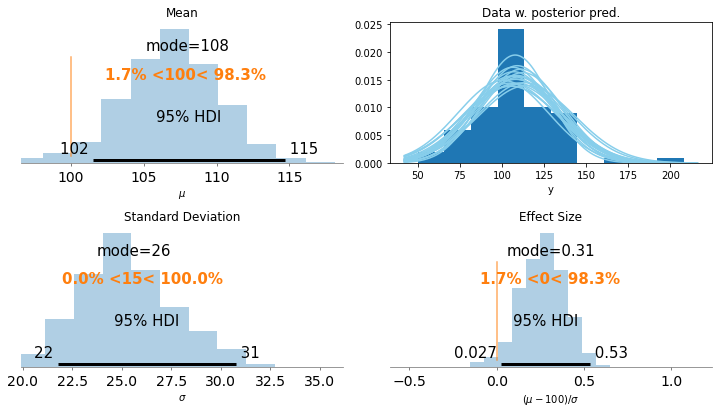

In [11]:
fig = plots.plot_st(
    mcmc, smart_group_data.Score.values,
    mean_comp_val=100,
    std_comp_val=15,
    effsize_comp_val=0,
)

## Outliers and Robust Estimation: $t$ Distribution

### Robust Metric Model

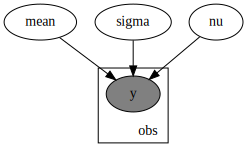

In [12]:
numpyro.render_model(
    glm_metric.one_group_robust,
    model_args=(jnp.ones(5),),
    render_params=True)

### Synthesis Data

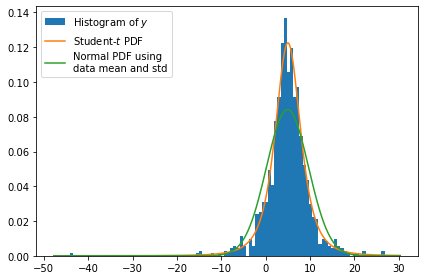

In [13]:
MEAN = 5
SIGMA = 3
NORMALITY = 3
N = 1000

y = np.random.standard_t(NORMALITY, size=N) * SIGMA + MEAN

# Plot the histogram and true PDF of normal distribution.
fig, ax = plt.subplots()
ax.hist(y, density=True, bins=100, label='Histogram of $y$')
xmin, xmax = ax.get_xlim()
p = np.linspace(xmin, xmax, 1000)
ax.plot(p, t.pdf(p, loc=MEAN, scale=SIGMA, df=NORMALITY), label='Student-$t$ PDF')
ax.plot(p, norm.pdf(p, loc=y.mean(), scale=y.std()),
        label='Normal PDF using\ndata mean and std')
ax.legend()
fig.tight_layout()

Using the robust metric model on our synthesis data
to see if it can recover the original parameters.

In [14]:
mcmc_key = random.PRNGKey(0)
kernel = NUTS(glm_metric.one_group_robust)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, jnp.array(y))
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mean      4.97      0.12      4.97      4.77      5.17    503.73      1.00
        nu      3.22      0.37      3.19      2.63      3.84    336.57      1.00
     sigma      3.02      0.13      3.02      2.81      3.23    331.34      1.00

Number of divergences: 0


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

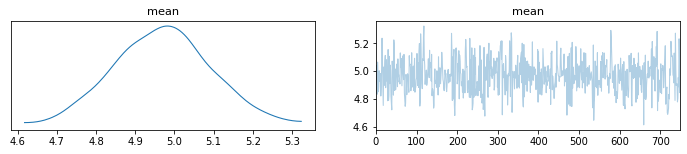

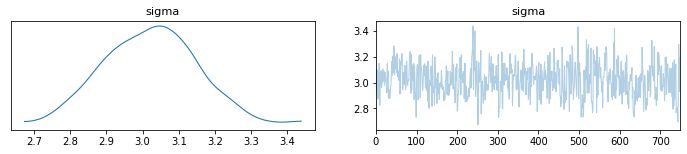

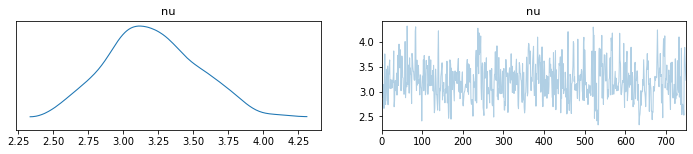

In [15]:
numpyro_glm.plot_diagnostic(mcmc, ['mean', 'sigma', 'nu'])

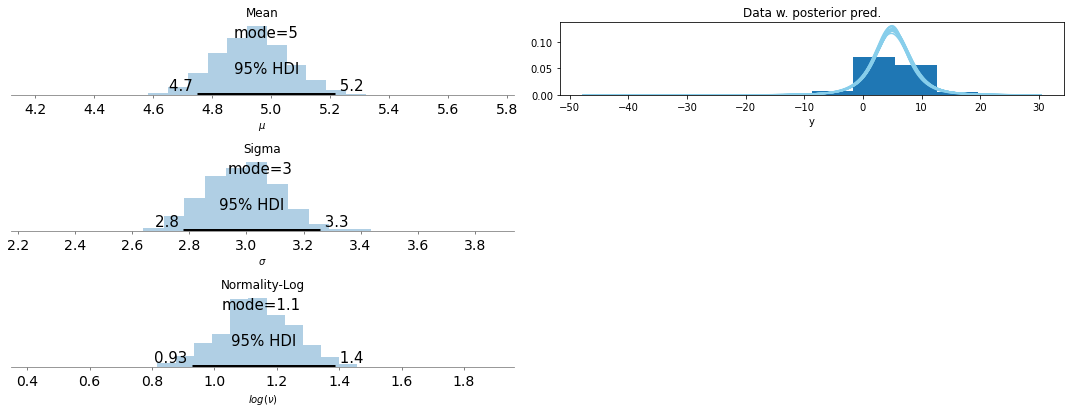

In [16]:
fig = plots.plot_st_2(mcmc, y)

### Smart Drug Group Data

In [17]:
mcmc_key = random.PRNGKey(0)
kernel = NUTS(glm_metric.one_group_robust)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, jnp.array(smart_group_data.Score.values))
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mean    107.38      2.82    107.37    102.86    111.82    676.09      1.00
        nu      9.50     12.03      5.38      1.15     20.90    214.95      1.00
     sigma     19.65      3.47     19.58     14.16     25.52    196.94      1.00

Number of divergences: 0


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

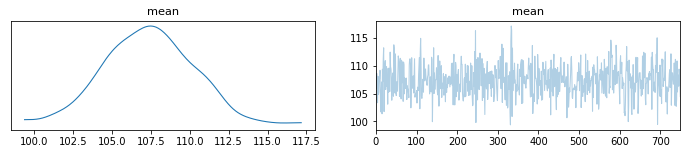

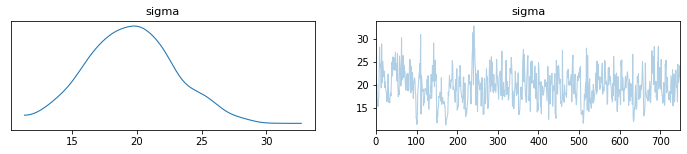

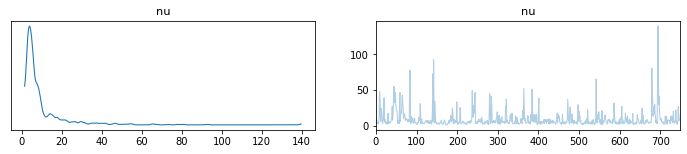

In [18]:
numpyro_glm.plot_diagnostic(mcmc, ['mean', 'sigma', 'nu'])

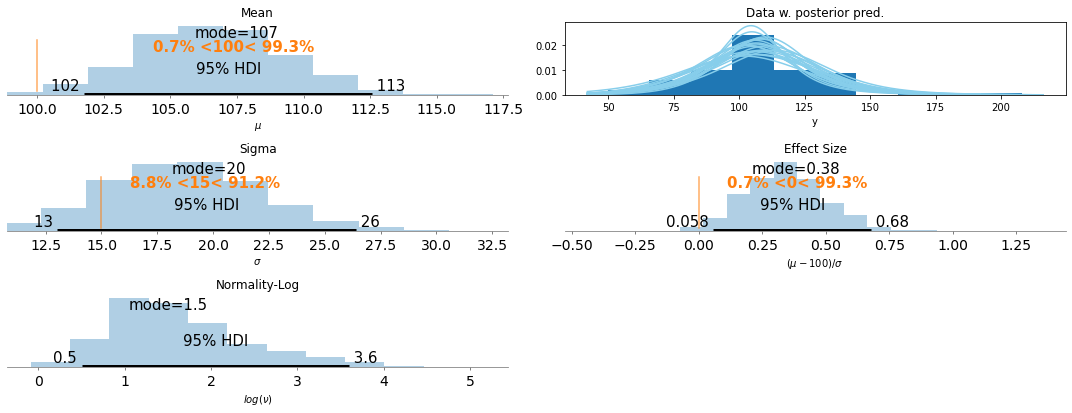

In [19]:
fig = plots.plot_st_2(
    mcmc, smart_group_data.Score.values,
    mean_comp_val=100,
    sigma_comp_val=15,
    effsize_comp_val=0)

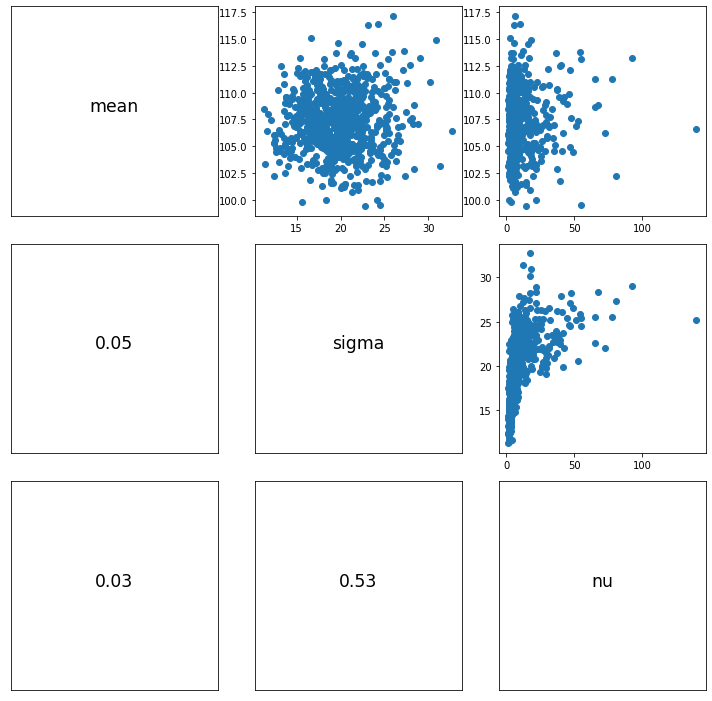

In [20]:
fig = numpyro_glm.plot_pairwise_scatter(mcmc, ['mean', 'sigma', 'nu'])

## Two Groups

In [21]:
mcmc_key = random.PRNGKey(0)
kernel = NUTS(glm_metric.multi_groups_robust)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(
    mcmc_key,
    jnp.array(iq_data['Score'].values),
    jnp.array(iq_data['Group'].cat.codes.values),
    len(iq_data['Group'].cat.categories),
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   mean[0]     99.30      1.88     99.22     96.66    102.88    754.40      1.00
   mean[1]    107.15      2.58    107.16    102.88    111.40    656.45      1.00
        nu      3.94      1.72      3.57      1.89      5.97    343.63      1.00
  sigma[0]     11.40      1.77     11.26      8.82     14.42    619.52      1.00
  sigma[1]     17.94      2.87     17.77     13.08     22.42    651.97      1.00

Number of divergences: 0


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

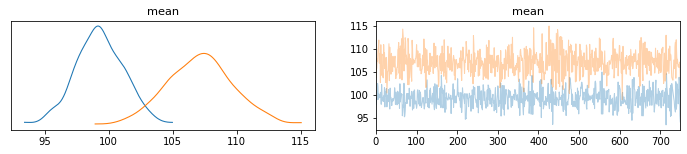

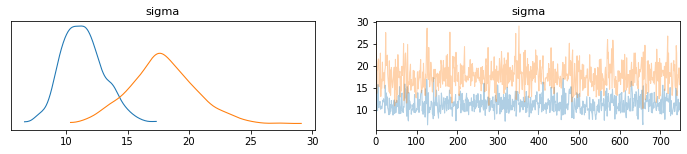

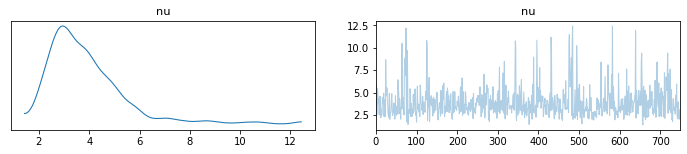

In [22]:
numpyro_glm.plot_diagnostic(mcmc, ['mean', 'sigma', 'nu'])

Plot the resulting posteriors.

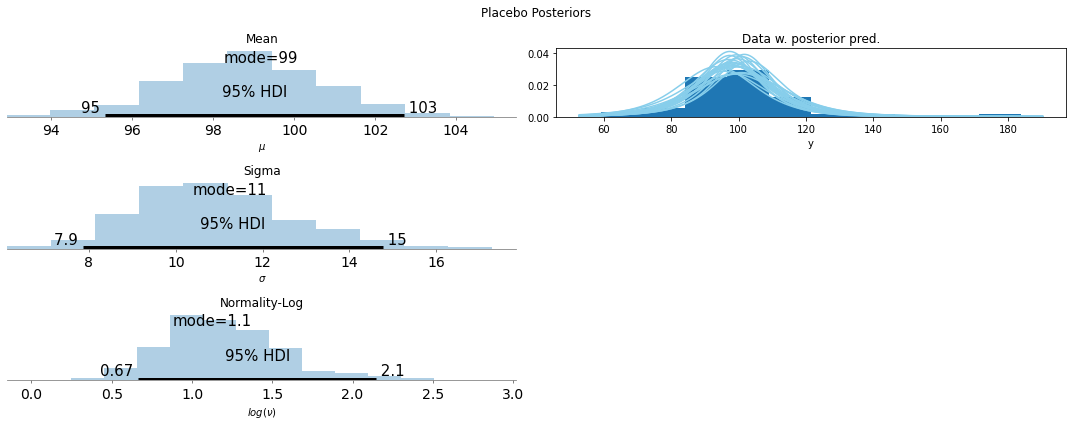

In [23]:
fig = plots.plot_st_2(
    mcmc,
    iq_data[iq_data['Group'] == 'Placebo']['Score'].values,
    mean_coords=dict(mean_dim_0=0),
    sigma_coords=dict(sigma_dim_0=0),
    figtitle='Placebo Posteriors')

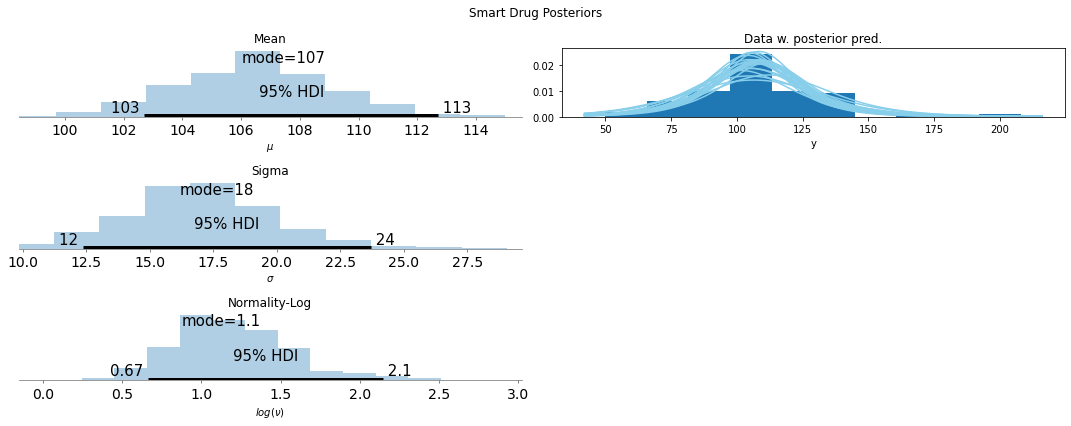

In [24]:
fig = plots.plot_st_2(
    mcmc,
    iq_data[iq_data['Group'] == 'Smart Drug']['Score'].values,
    mean_coords=dict(mean_dim_0=1),
    sigma_coords=dict(sigma_dim_0=1),
    figtitle='Smart Drug Posteriors')

Then, we will plot the difference between the two groups.

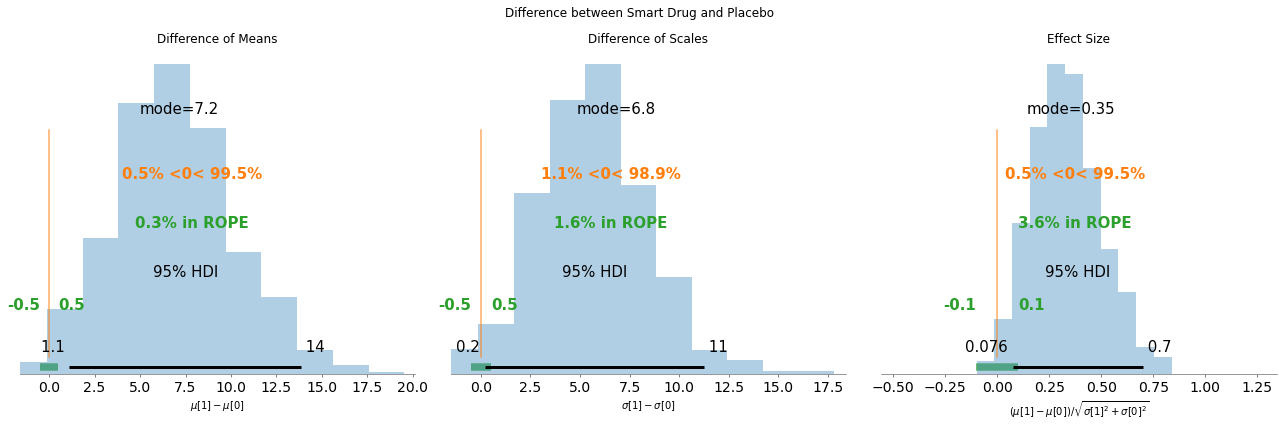

In [25]:
idata = az.from_numpyro(mcmc)
posteriors = idata.posterior

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
fig.suptitle('Difference between Smart Drug and Placebo')

# Plot mean difference.
ax = axes[0]
mean_difference = (posteriors['mean'].sel(dict(mean_dim_0=1))
                   - posteriors['mean'].sel(dict(mean_dim_0=0)))
az.plot_posterior(
    mean_difference,
    hdi_prob=0.95,
    ref_val=0,
    rope=(-0.5, 0.5),
    point_estimate='mode',
    kind='hist',
    ax=ax)
ax.set_title('Difference of Means')
ax.set_xlabel('$\mu[1] - \mu[0]$')

# Plot sigma difference.
ax = axes[1]
sigma_difference = (posteriors['sigma'].sel(dict(sigma_dim_0=1))
                    - posteriors['sigma'].sel(dict(sigma_dim_0=0)))
az.plot_posterior(
    sigma_difference,
    hdi_prob=0.95,
    ref_val=0,
    rope=(-0.5, 0.5),
    point_estimate='mode',
    kind='hist',
    ax=ax)
ax.set_title('Difference of Scales')
ax.set_xlabel('$\sigma[1] - \sigma[0]$')

# Plot effect size.
ax = axes[2]
sigmas_squared = (posteriors['sigma'].sel(dict(sigma_dim_0=1))**2
                  + posteriors['sigma'].sel(dict(sigma_dim_0=0))**2)
effect_size = mean_difference / np.sqrt(sigmas_squared)
az.plot_posterior(
    effect_size,
    hdi_prob=0.95,
    ref_val=0,
    rope=(-0.1, 0.1),
    point_estimate='mode',
    kind='hist',
    ax=ax)
ax.set_title('Effect Size')
ax.set_xlabel('$(\mu[1] - \mu[0]) / \sqrt{\sigma[1]^2 + \sigma[0]^2}$')

fig.tight_layout()